In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle/StrokePrediction"

In [ ]:
%cd /content/gdrive/My Drive/kaggle/StrokePrediction

/content/gdrive/My Drive/kaggle/StrokePrediction


In [ ]:
!ls

healthcare-dataset-stroke-data.csv  model_stacked.pickle  y_re.pickle
kaggle.json			    X_re.pickle		  y_test.pickle
model.pickle			    X_test.pickle


In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 4.5MB/s 


In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 6.8MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 481kB 43.7MB/s 
     |████████████████████████████████| 112kB 41.5MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 143kB 30.7MB/s 
  Created wheel for alembic: filename=alembic-1.5.4-py2.py3-none-any.whl size=156314 sha256=3b113c3f6bb61fcff48ff97d56b3b17cdae66137227e08d2f6e74c2676c1ee5a
  Stored in directory: /root/.cache/pip/wheels/fd/2d/ec/5a1b1e2363ed68392d292d215facf588d5448198edd8078bc1
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=76191cf9e4a7d307aa5a2030c2c8d5f2445d8878eb9914663e8fd6592c2a8922
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha256=

#Hyper-parameter optimisation

HPO is the process of finding a set of optimal hyperparameters for a learning system . HPO is an essential step in ensuring that the final model generalizes well in different situations . We are going to optimize our hyperparameters by using the following methods:


1.   Bayesian optimisation
2.   HPO using TPE (Hyperopt)
3.   HPO using Optuna

---



Importing essentials

In [ ]:
import pandas as pd 
import numpy as np
import pickle as pk
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import metrics
from skopt import space,gp_minimize
from functools import partial
from hyperopt import hp,fmin,tpe,Trials
from hyperopt.pyll.base import scope
import optuna

Loading the training data and the test data

In [ ]:
with open("X_re.pickle","rb") as f:
  X_train=pk.load(f)
with open('y_re.pickle',"rb") as f:
  y_train=pk.load(f)
with open("X_test.pickle","rb") as f:
  X_test=pk.load(f)
with open('y_test.pickle',"rb") as f:
  y_test=pk.load(f)  

In [ ]:
def get_models():
  models=list()
  models.append(("lr",LogisticRegression()))
  models.append(("rf",RandomForestClassifier()))
  models.append(("nb",GaussianNB()))
  models.append(("svm",SVC()))
  return models

###Bayesian Optimisation 

Optimize function

In [ ]:
def optimize(params,param_names,x,y,base_models):
  params=dict(zip(param_names,params))
  stacked_model=RandomForestClassifier(**params)
  model=StackingClassifier(estimators=base_models,final_estimator=stacked_model,cv=5)
  kf=model_selection.StratifiedKFold(n_splits=5)
  accuracies=[] #accuracies for all the fold
  for idx in kf.split(X=x,y=y):
    train_idx,test_idx=idx[0],idx[1]

    #train split
    xtrain=x[train_idx]
    ytrain=y[train_idx]

    #test split
    xtest=x[test_idx]
    ytest=y[test_idx]

    model.fit(xtrain,ytrain) #fitting the stacked model
    preds=model.predict_proba(xtest)
    preds=preds[:,1]
    fold_acc=metrics.roc_auc_score(ytest,preds)
    accuracies.append(fold_acc) 
  
  return -1.0*np.mean(accuracies)

Defining the parameter space and the parameter names 

In [ ]:
param_space=[
             space.Integer(3,10,name="max_depth"),
             space.Categorical(["gini","entropy"],name="criterion"),
             space.Integer(100,500,name="n_estimators"),
             space.Real(0.01,1,prior="uniform",name="max_features")
]
param_names=[
             "max_depth",
             "criterion",
             "n_estimators",
             "max_features"
]

Now we do optimization using gp_minimize

In [ ]:
optmization_function=partial(optimize,
                             param_names=param_names,
                             x=X_train,
                             y=y_train,
                             base_models=get_models())
result=gp_minimize(optmization_function,
                   dimensions=param_space,
                   n_calls=5,
                   n_random_starts=5,
                   verbose=10,
                   n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 40.7732
Function value obtained: -0.9894
Current minimum: -0.9894
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 36.2635
Function value obtained: -0.9888
Current minimum: -0.9894
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 43.5193
Function value obtained: -0.9900
Current minimum: -0.9900
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 43.8138
Function value obtained: -0.9901
Current minimum: -0.9901
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 49.6882
Function value obtained: -0.9885
Current minimum: -0.9901


Final results

In [ ]:
print(dict(zip(param_names,result.x)))

{'max_depth': 3, 'criterion': 'entropy', 'n_estimators': 295, 'max_features': 0.7979762924139232}


###HPO using Hyperopt

Defining the optimize function

In [ ]:
def optimize(params,x,y,base_models):
  stacked_model=RandomForestClassifier(**params)
  model=StackingClassifier(estimators=base_models,final_estimator=stacked_model,cv=5)
  kf=model_selection.StratifiedKFold(n_splits=5)
  accuracies=[] #accuracies for all the fold
  for idx in kf.split(X=x,y=y):
    train_idx,test_idx=idx[0],idx[1]

    #train split
    xtrain=x[train_idx]
    ytrain=y[train_idx]

    #test split
    xtest=x[test_idx]
    ytest=y[test_idx]

    model.fit(xtrain,ytrain) #fitting the stacked model
    preds=model.predict_proba(xtest)
    preds=preds[:,1]
    fold_acc=metrics.roc_auc_score(ytest,preds)
    accuracies.append(fold_acc) 
  
  return -1.0*np.mean(accuracies)

Creating the parameter space

In [ ]:
param_space={
    "max_depth":scope.int(hp.quniform("max_depth",3,10,1)),
    "criterion":hp.choice("criterion",["gini","entropy"]),
    "n_estimators":scope.int(hp.quniform("n_estimators",100,500,1)),
    "max_features":hp.uniform("max_features",0.01,1)
}

Now we optimize using fmin from Hyperopt

In [ ]:
optmization_function=partial(optimize,
                             x=X_train,
                             y=y_train,
                             base_models=get_models())

In [ ]:
trials=Trials()

In [ ]:
result=fmin(fn=optmization_function,
            space=param_space,
            algo=tpe.suggest,
            max_evals=15,
            trials=trials,
            
)

100%|██████████| 15/15 [10:30<00:00, 42.04s/it, best loss: -0.9898109728841039]


Final results

In [ ]:
print(result)

{'criterion': 0, 'max_depth': 10.0, 'max_features': 0.24223551097941823, 'n_estimators': 141.0}


###HPO using Optuna

Defining the optimize function

In [ ]:
def optimize(trial,x,y,base_models):
  criterion=trial.suggest_categorical("criterion",["gini","entropy"])
  n_estimators=trial.suggest_int("n_estimators",100,500)
  max_depth=trial.suggest_int("max_depth",3,10)
  max_features=trial.suggest_uniform("max_features",0.01,1.0)

  stacked_model=RandomForestClassifier(
      n_estimators=n_estimators,
      max_depth=max_depth,
      max_features=max_features,
      criterion=criterion
  )
  model=StackingClassifier(estimators=base_models,final_estimator=stacked_model,cv=5)
  kf=model_selection.StratifiedKFold(n_splits=5)
  accuracies=[] #accuracies for all the fold
  for idx in kf.split(X=x,y=y):
    train_idx,test_idx=idx[0],idx[1]

    #train split
    xtrain=x[train_idx]
    ytrain=y[train_idx]

    #test split
    xtest=x[test_idx]
    ytest=y[test_idx]

    model.fit(xtrain,ytrain) #fitting the stacked model
    preds=model.predict_proba(xtest)
    preds=preds[:,1]
    fold_acc=metrics.roc_auc_score(ytest,preds)
    accuracies.append(fold_acc) 
  
  return -1.0*np.mean(accuracies)

Now we optimize using Optuna

In [ ]:
optimization_function=partial(optimize,x=X_train,y=y_train,base_models=get_models())

In [ ]:
study= optuna.create_study(direction="minimize")

[I 2021-02-17 11:48:25,987] A new study created in memory with name: no-name-5f1fe833-7ad5-4165-85e4-c728fe7b0265


Final results

In [ ]:
study.optimize(optimization_function,n_trials=15)

[I 2021-02-17 11:49:09,951] Trial 0 finished with value: -0.9892223640690595 and parameters: {'criterion': 'entropy', 'n_estimators': 477, 'max_depth': 4, 'max_features': 0.33666211879018004}. Best is trial 0 with value: -0.9892223640690595.
[I 2021-02-17 11:49:59,559] Trial 1 finished with value: -0.987952647990026 and parameters: {'criterion': 'gini', 'n_estimators': 360, 'max_depth': 10, 'max_features': 0.9883961287774781}. Best is trial 0 with value: -0.9892223640690595.
[I 2021-02-17 11:50:39,965] Trial 2 finished with value: -0.9894500909587582 and parameters: {'criterion': 'gini', 'n_estimators': 337, 'max_depth': 6, 'max_features': 0.04242281336983184}. Best is trial 2 with value: -0.9894500909587582.
[I 2021-02-17 11:51:21,928] Trial 3 finished with value: -0.9902304278723563 and parameters: {'criterion': 'entropy', 'n_estimators': 324, 'max_depth': 6, 'max_features': 0.47622987153704094}. Best is trial 3 with value: -0.9902304278723563.
[I 2021-02-17 11:52:15,768] Trial 4 fin

#Evaluating the optimized model

Finally , it's time to evaluate our final model and see it performance .

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Now that we have completed HPO , we are going to use the hyperparameters suggested by **Optuna**

In [ ]:
meta_model=RandomForestClassifier(criterion= 'entropy', n_estimators= 324, max_depth= 6, max_features=0.476223)
stacked=StackingClassifier(estimators=get_models(),final_estimator=meta_model,cv=10)
stacked.fit(X_train,y_train)

StackingClassifier(cv=10,
                   estimators=[('lr',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False)),
                               ('rf',
                                RandomForestClassifier(bootstrap=True,
                                 

###Using confusion matrix and k-fold cross validation

Making a confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,stacked.predict(X_test))

array([[952,   8],
       [ 57,   5]])

K-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(stacked,X_train,y_train,cv=10)
scores

array([0.83226633, 0.97695262, 0.98974359, 0.98205128, 0.97179487,
       0.99230769, 0.98974359, 0.99230769, 0.99230769, 0.9974359 ])

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.97 accuracy with a standard deviation of 0.05


###Using AUC and ROC

Defining the function to plot the ROC curve

In [ ]:
def plot_roc_curve(fpr, tpr):
  # tpr=True Positive Rate
  # fpr=False Positive Rate
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--') #diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

Predicting the probablities of the testing set

In [ ]:
probs=stacked.predict_proba(X_test)

In [ ]:
prob_positive=probs[:,1] # keeping the probablities of the positive class only

**Area under the curve (AUC)**

In [ ]:
auc=roc_auc_score(y_test,prob_positive)
print("AUC:%.2f"% auc)

AUC:0.83


**ROC curve**

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, prob_positive)

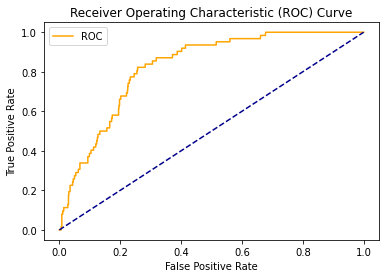

In [ ]:
plot_roc_curve(fpr, tpr)